In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pickle
import normalize_data
import random
import train

pd.set_option('display.max_columns', 999)
pd.set_option('display.precision', 10)

In [2]:
def get_ref_X_y(df):
    ref_cols = [c for c in df.columns if c.startswith('__')]
    X_cols = [c for c in df.columns if c.startswith('X_')]
    y_cols = [c for c in df.columns if c.startswith('y_')]
    return (df[ref_cols], df[X_cols], df[y_cols])

In [22]:
raw_data = {} # loads raw data and stores as a dict cache

def dataset_key(dataset='', validation=False):
    return dataset+('test' if validation else 'train')


def load_data(raw, dataset='', validation=False):
    '''
    Return dataframe matching data set and validation. Dictionary input will be updated.

    Parameters
    ----------
    raw : dict
        dictionary which caches the dataframes and will be updated accordingly

    dataset : str
        which dataset to use? valid input includes: empty str for full set, sample_, and secret_

    validation : bool
        load validation set? if true then use _test, otherwise use _train.  Note secret_ doesn't have _train
    '''
    key = dataset+('test' if validation else 'train')
    if key not in raw:
        print(f"Loading data to cache for: {key}")
        raw[key] = pd.read_pickle(f'{os.environ["GP_HIST_PATH"]}/../t4_data/{key}.pkl')
    return raw[key]

In [23]:
configurations = {
    'dataset' : 'sample_', # '', 'sample_', 'secret_'
    'model_identifier' : "split_model_1",
    'model_path' : f"{os.environ['GP_HIST_PATH']}/../t4_models",
    'train_params' : {
        'batch_size': 50000,
        'shuffle': True,
        'num_workers': 3,
        'pin_memory': True,
    },
    'test_params' : {
        'batch_size': 200000,
        'num_workers': 2,
        'pin_memory': True,
    },
}

In [24]:
%%time

train_df = normalize_data.normalize_all_columns(load_data(raw_data,dataset=configurations['dataset'],validation=False))
test_df = normalize_data.normalize_all_columns(load_data(raw_data,dataset=configurations['dataset'],validation=True))

train_df = train_df.dropna()
test_df = test_df.dropna()
# train_df = train_df.sample(100000, random_state=42)
# test_df = test_df.sample(10000, random_state=42)

Loading data to cache for: sample_train
Loading data to cache for: sample_test
CPU times: user 898 ms, sys: 438 ms, total: 1.34 s
Wall time: 1.05 s


In [25]:
ref_train, X_train, y_train = get_ref_X_y(train_df)
ref_test, X_test, y_test = get_ref_X_y(test_df)

In [26]:
y_cols = ['y_INCLINATION', 'y_ECCENTRICITY', 'y_MEAN_MOTION', 'y_RA_OF_ASC_NODE_REG', 'y_RA_OF_ASC_NODE', 'y_ARG_OF_PERICENTER_REG', 'y_ARG_OF_PERICENTER', 'y_BSTAR', 'y_REV_MA_REG', 'y_MEAN_ANOMALY']
y_cols = ['y_INCLINATION', 'y_ECCENTRICITY', 'y_MEAN_MOTION', 'y_RA_OF_ASC_NODE_REG', 'y_ARG_OF_PERICENTER_REG', 'y_REV_MA_REG']

y_train = y_train[y_cols]
y_test = y_test[y_cols]

# y_train = np.sign(y_train) * np.log(1+np.abs(y_train))
# y_test = np.sign(y_test) * np.log(1+np.abs(y_test))

In [27]:
# model, mean_losses = train.train_model(X_train, y_train, X_test, y_test, configurations, force_train=False)

Loading existing model


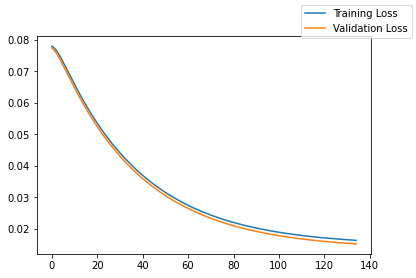

In [31]:
model, _, _, mean_losses, _ = train.load_model_with_config(configurations)

tl, vl = zip(*mean_losses)

fig,ax = plt.subplots()
ax.plot(tl, label="Training Loss")
ax.plot(vl, label="Validation Loss")

fig.legend()
plt.show()

In [32]:
trained_model = model

In [33]:
sample_idx = random.sample(list(X_test.index), 10000)

X_sample = X_test.loc[sample_idx]
y_sample = y_test.loc[sample_idx]

In [34]:
# y_train_pred = train.predict(trained_model, X_train, y_train, device="cpu") # get predictions for each train
# y_train_pred_df = pd.DataFrame(y_train_pred, columns=y_train.columns)  # put results into a dataframe
y_sample_pred = train.predict(trained_model, X_sample, y_sample, device="cpu") # get predictions for each train
y_sample_pred_df = pd.DataFrame(y_sample_pred, columns=y_sample.columns)  # put results into a dataframe

In [35]:
print(f'    Test set MAE (L1) loss: {mean_absolute_error(y_sample, y_sample_pred_df)}')
print(f'    Test set MSE (L2) loss: {mean_squared_error(y_sample, y_sample_pred_df)}')

# random.seed(342798)
sample = random.sample(list(y_sample_pred_df.index), 10)
# sample = [0,1]

print("Test - Ground Truth (normalized):")
display(y_sample)
print("Test - Prediction (normalized):")
display(y_sample_pred_df)
# print("Ground Truth Diffs from X_:")
# display(y_sample - X_sample[['X_INCLINATION_1','X_ECCENTRICITY_1','X_MEAN_MOTION_1']].values)
# print("Pred Diffs from X_:")
# display(y_sample_pred_df - X_sample[['X_INCLINATION_1','X_ECCENTRICITY_1','X_MEAN_MOTION_1']].values)


    Test set MAE (L1) loss: 0.0722974633437561
    Test set MSE (L2) loss: 0.01531012823080928
Test - Ground Truth (normalized):


,y_INCLINATION,y_ECCENTRICITY,y_MEAN_MOTION,y_RA_OF_ASC_NODE_REG,y_ARG_OF_PERICENTER_REG,y_REV_MA_REG
69411,0.5492733333,0.0140336,0.3231984789,0.3060675000,0.8645652778,0.9348324784
66669,0.5484655556,0.0405328,0.3392232789,0.5631247222,0.2295413889,1.1085997037
65982,0.5482894444,0.0394696,0.3401159726,0.0812094444,0.7896630556,0.5578624969
62758,0.5490794444,0.0395872,0.3396760423,0.2047763889,0.8093755556,0.9482015556
57500,0.5501061111,0.0652364,0.3676072800,0.4881833333,0.1053316667,1.0099794753
...,...,...,...,...,...,...
16709,0.3690700000,0.1372456,0.3304984480,0.3891894444,0.9286119444,0.3340781759
49813,0.5497383333,0.0697584,0.3610406354,0.7364969444,0.6918250000,0.5589255247
74970,0.2389627778,0.0973748,0.3735999223,0.7991138889,0.7888844444,0.6355984105
75352,0.2389744444,0.0980288,0.3733001131,0.0618591667,0.7810897222,0.6356834753


Test - Prediction (normalized):


,y_INCLINATION,y_ECCENTRICITY,y_MEAN_MOTION,y_RA_OF_ASC_NODE_REG,y_ARG_OF_PERICENTER_REG,y_REV_MA_REG
0,0.5917682648,-0.0132412128,0.2774997652,0.3338720202,0.9253484011,0.3802417517
1,0.5909656286,0.0132385083,0.2948922217,0.5880703330,0.2996572554,1.0093986988
2,0.5907887816,0.0121035073,0.2910616696,0.1156683564,0.8326024413,0.4711199999
3,0.5915771127,0.0123129953,0.2939852476,0.2322289795,0.8720992208,0.6108486652
4,0.5925992131,0.0380093642,0.3222573698,0.5138673782,0.1708273143,1.1393622160
...,...,...,...,...,...,...
9995,0.4115665853,0.1097619012,0.2795265913,0.4485079050,0.9467817545,0.3556669950
9996,0.5922293067,0.0423135534,0.3119157553,0.7704872489,0.7352775335,0.5657500625
9997,0.2814663649,0.0699839443,0.3250951171,0.8979030252,0.7410539389,0.5575097799
9998,0.2814719081,0.0706939623,0.3247981369,0.1606355011,0.7333178520,0.5652490258


In [36]:
# print(f'    Train set MAE (L1) loss: {mean_absolute_error(y_train, y_train_pred_df)}')
# print(f'    Train set MSE (L2) loss: {mean_squared_error(y_train, y_train_pred_df)}')

# random.seed(0)
# sample = random.sample(list(y_train_pred_df.index), 10)

# print("Train - Ground Truth (normalized):")
# display(y_train.loc[sample])
# # print("Train - Ground Truth (non-normalized):")
# # display(normalize_data.normalize_all_columns(y_train.iloc[:,3:].loc[sample].copy(), reverse=True))  # see ground truths
# print("Train - Prediction (normalized):")
# display(y_train_pred_df.loc[sample])
# # print("Train - Prediction (non-normalized):")
# # display(normalize_data.normalize_all_columns(y_train_pred_df.loc[sample].copy(), reverse=True))  # See predictions

In [15]:
# errors = y_train.loc[sample].iloc[:,3:] - y_train_pred_df.loc[sample]

# display(errors)

# display(errors.std())

# display(y_train.loc[sample].iloc[:,3:])
# display(y_train_pred_df.loc[sample])

In [16]:
# def row_to_compare(X, y, y_pred, row):
#     epoch = X.iloc[row].EPOCH_y
#     X0 = clean_data.normalize_all_columns(X_train.iloc[row].copy(), reverse=True)
#     y0 = clean_data.normalize_all_columns(y_train.iloc[row].copy(), reverse=True)
#     y1 = clean_data.normalize_all_columns(y_train_pred_df.iloc[row].copy(), reverse=True)

#     # Ground truth
#     y0_xyz = clean_data.get_satellite_xyz(bst=0.0001,
#                                           ecc=y0.ECCENTRICITY,
#                                           aop=y0.ARG_OF_PERICENTER,
#                                           inc=y0.INCLINATION,
#                                           mea=y0.MEAN_ANOMALY,
#                                           mem=y0.MEAN_MOTION,
#                                           raa=y0.RA_OF_ASC_NODE,
#                                           epoch=epoch,)
#     # Prediction
#     y1_xyz = clean_data.get_satellite_xyz(bst=0.0001,
#                                           ecc=y1.ECCENTRICITY,
#                                           aop=y1.ARG_OF_PERICENTER,
#                                           inc=y1.INCLINATION,
#                                           mea=y1.MEAN_ANOMALY,
#                                           mem=y1.MEAN_MOTION,
#                                           raa=y1.RA_OF_ASC_NODE,
#                                           epoch=epoch,)
#     # Propigation
#     y2_xyz = clean_data.get_satellite_xyz(bst=X0.BSTAR,
#                                           ecc=X0.ECCENTRICITY,
#                                           aop=X0.ARG_OF_PERICENTER,
#                                           inc=X0.INCLINATION,
#                                           mea=X0.MEAN_ANOMALY,
#                                           mem=X0.MEAN_MOTION,
#                                           raa=X0.RA_OF_ASC_NODE,
#                                           epoch=epoch,)
#     print(f'Ground Truth: {y0_xyz}')
#     print(f'Predicted: {y1_xyz}')
#     print(f'Propigation: {y2_xyz}')
    
#     print (f'Prediction Error: {sum((y1_xyz-y0_xyz)**2)**0.5} km')
#     print (f'Propigation Error: {sum((y2_xyz-y0_xyz)**2)**0.5} km')
    

# for row in range(2):
#     print (f'Row {row}:')
#     row_to_compare(X_train, y_train, y_train_pred_df, row)
#     print('')